In [1]:
import numpy as np
import scipy
import scipy.stats
import pandas as pd
import sunpy.map
import cv2
import skimage
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers

import autoenc_model as aem

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
# Read images
AIA193_2016 = sunpy.map.Map("data/aia_193A/2016*.fits")
AIA193_2016_matrix = np.array(list(d.data for d in AIA193_2016))


# Normalize images
min_values = AIA193_2016_matrix.min(axis=2).min(axis=1)
max_values = AIA193_2016_matrix.max(axis=2).max(axis=1)

rg = max_values - min_values
rg = np.maximum(rg, 1e-4*np.ones(rg.shape)).reshape([-1,1,1])

AIA193_2016_mnorm = (AIA193_2016_matrix-min_values.reshape([-1,1,1])) / rg


# Discretize images to detect faulty data
AIA193_2016_bytes = np.round(AIA193_2016_mnorm*255).astype(np.uint8)


# Calculate histograms
nbins = 10
hist_vectors = np.array([np.histogram(i.flatten(), bins=np.linspace(0,256,nbins))[0] for i in AIA193_2016_bytes])


# Cluster histograms
kmeans = KMeans(n_clusters=2, n_init=10)
kmeans.fit(hist_vectors/hist_vectors.max())

class1 = AIA193_2016_bytes[kmeans.labels_ == kmeans.labels_[0], :, :]
class2 = AIA193_2016_bytes[kmeans.labels_ != kmeans.labels_[0], :, :]

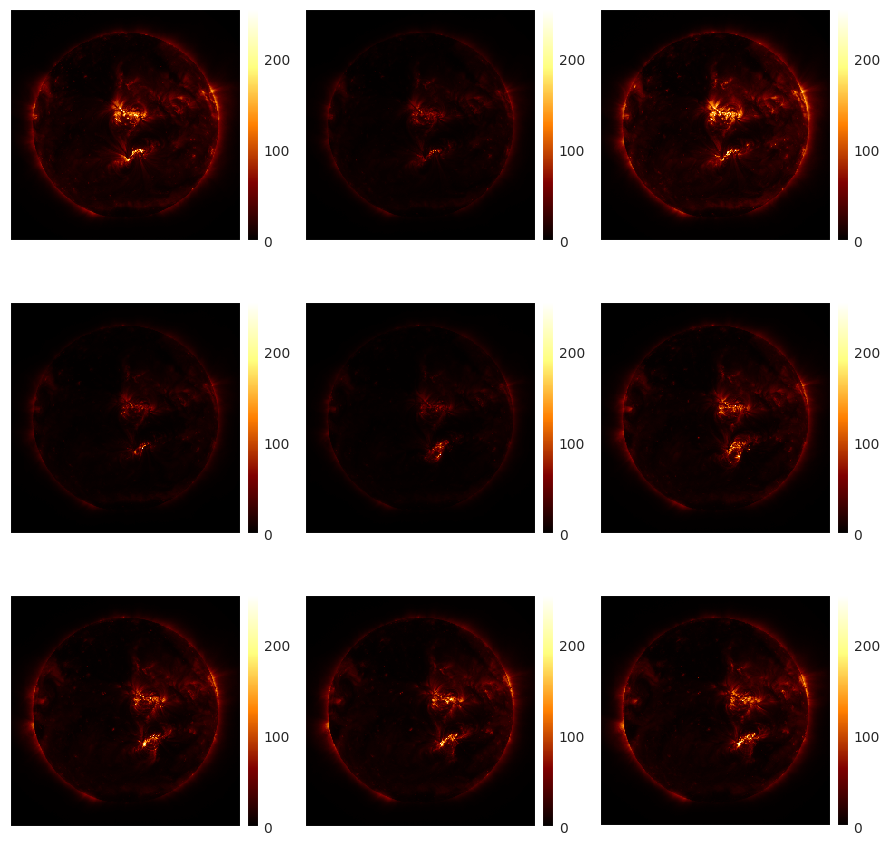

In [3]:
isns.ImageGrid([i for i in class1[:9]], cmap="afmhot") # class2 is (probably) noise 

In [4]:
clean_input = AIA193_2016_mnorm[kmeans.labels_ == kmeans.labels_[0], :, :]

In [5]:
# input_img = keras.Input(shape=[256,256,1])
# latent_size = 64

# # lrelu = layers.LeakyReLU(0.2)
# optim = keras.optimizers.Adam(0.001)
# # optim = keras.optimizers.SGD(0.001)
# loss = "mse"


# #x = layers.Reshape([256,256,1])(input_img)
# x = input_img
# x = layers.Conv2D(8, 3, activation="relu", padding='same', strides=1)(x)
# x = layers.Conv2D(8, 3, activation="relu", padding='same', strides=1)(x)
# x = layers.MaxPooling2D()(x)

# x = layers.Conv2D(16, 3, activation="relu", padding='same', strides=1)(x)
# x = layers.Conv2D(16, 3, activation="relu", padding='same', strides=1)(x)
# x = layers.MaxPooling2D()(x)

# x = layers.Conv2D(32, 3, activation="relu", padding='same', strides=1)(x)
# x = layers.Conv2D(32, 3, activation="relu", padding='same', strides=1)(x)
# x = layers.MaxPooling2D()(x)

# x = layers.Flatten()(x)
# x = layers.Dropout(0.2)(x)
# x = layers.Dense(128, activation="relu")(x)
# x = layers.Dropout(0.1)(x)
# encoded = layers.Dense(code_size, activation="sigmoid")(x)

# x = layers.Dense(256, activation="relu")(encoded)

# x = layers.Reshape([8, 8, 4])(x)
# x = layers.UpSampling2D()(x)

# x = layers.Conv2D(64, 3, activation="relu", padding='same', strides=1)(x)
# x = layers.Conv2DTranspose(64, 3, activation="relu", padding='same', strides=2)(x)

# x = layers.Conv2D(32, 3, activation="relu", padding='same', strides=1)(x)
# x = layers.Conv2DTranspose(32, 3, activation="relu", padding='same', strides=2)(x)

# x = layers.Conv2D(16, 3, activation="relu", padding='same', strides=1)(x)
# x = layers.Conv2DTranspose(16, 3, activation="relu", padding='same', strides=2)(x)

# x = layers.Conv2D(16, 3, activation="relu", padding='same', strides=1)(x)
# x = layers.Conv2DTranspose(1, 3, activation="relu", padding='same', strides=2)(x)

# #decoded = layers.Reshape([256,256])(x)
# decoded = x


# encoder = keras.Model(input_img, encoded)
# decoder = keras.Model(encoded, decoded)
# print(encoder.summary())
# decoder.summary()


# autoencoder = keras.Model(input_img, decoder(encoder(input_img)))
# autoencoder.compile(loss=loss, optimizer=optim, metrics=["mae"])
# autoencoder.summary()

latent_size = 64
autoencoder, encoder, decoder = gen_autoenc_model(latent_size, optim="adam", loss="mse")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 8)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        4640  

2023-02-22 10:30:44.357991: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/eugenio/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-02-22 10:30:44.358173: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-22 10:30:44.358188: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eugenio-desktop): /proc/driver/nvidia/version does not exist
2023-02-22 10:30:44.358789: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 model (Functional)          (None, 64)                4208576   
                                                                 
 model_1 (Functional)        (None, 256, 256, 1)       40231     
                                                                 
Total params: 4,248,807
Trainable params: 4,248,807
Non-trainable params: 0
_________________________________________________________________


In [6]:
clean_input_train, clean_input_test = train_test_split(clean_input, test_size=0.25)

In [7]:
n_epochs = 100
batch_size = 128

print(clean_input_train.shape)
history = autoencoder.fit(clean_input_train.reshape([-1, 256,256,1]), clean_input_train.reshape([-1, 256,256,1]), validation_split=0.2, epochs=n_epochs, batch_size=128)

(1856, 256, 256)
Epoch 1/100
15/15 [==============================] - 22s 1s/step - loss: 0.0030 - mae: 0.0297
Epoch 2/100
15/15 [==============================] - 19s 1s/step - loss: 0.0023 - mae: 0.0290
Epoch 3/100
15/15 [==============================] - 19s 1s/step - loss: 0.0019 - mae: 0.0254
Epoch 4/100
15/15 [==============================] - 19s 1s/step - loss: 0.0017 - mae: 0.0216
Epoch 5/100
15/15 [==============================] - 19s 1s/step - loss: 0.0015 - mae: 0.0188
Epoch 6/100
15/15 [==============================] - 19s 1s/step - loss: 0.0014 - mae: 0.0172
Epoch 7/100
15/15 [==============================] - 19s 1s/step - loss: 0.0013 - mae: 0.0164
Epoch 8/100
15/15 [==============================] - 19s 1s/step - loss: 0.0012 - mae: 0.0159
Epoch 9/100
15/15 [==============================] - 19s 1s/step - loss: 0.0012 - mae: 0.0154
Epoch 10/100
15/15 [==============================] - 20s 1s/step - loss: 0.0011 - mae: 0.0152
Epoch 11/100
15/15 [======================

20/20 [==============================] - 2s 77ms/step - loss: 6.2768e-04 - mae: 0.0111


KeyError: 'val_loss'

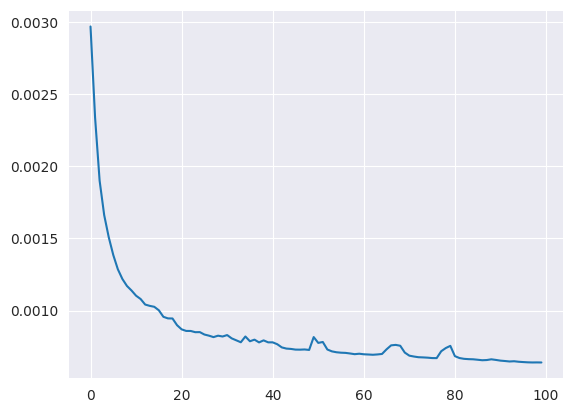

In [8]:
autoencoder.evaluate(clean_input_test, clean_input_test)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 21ms/step


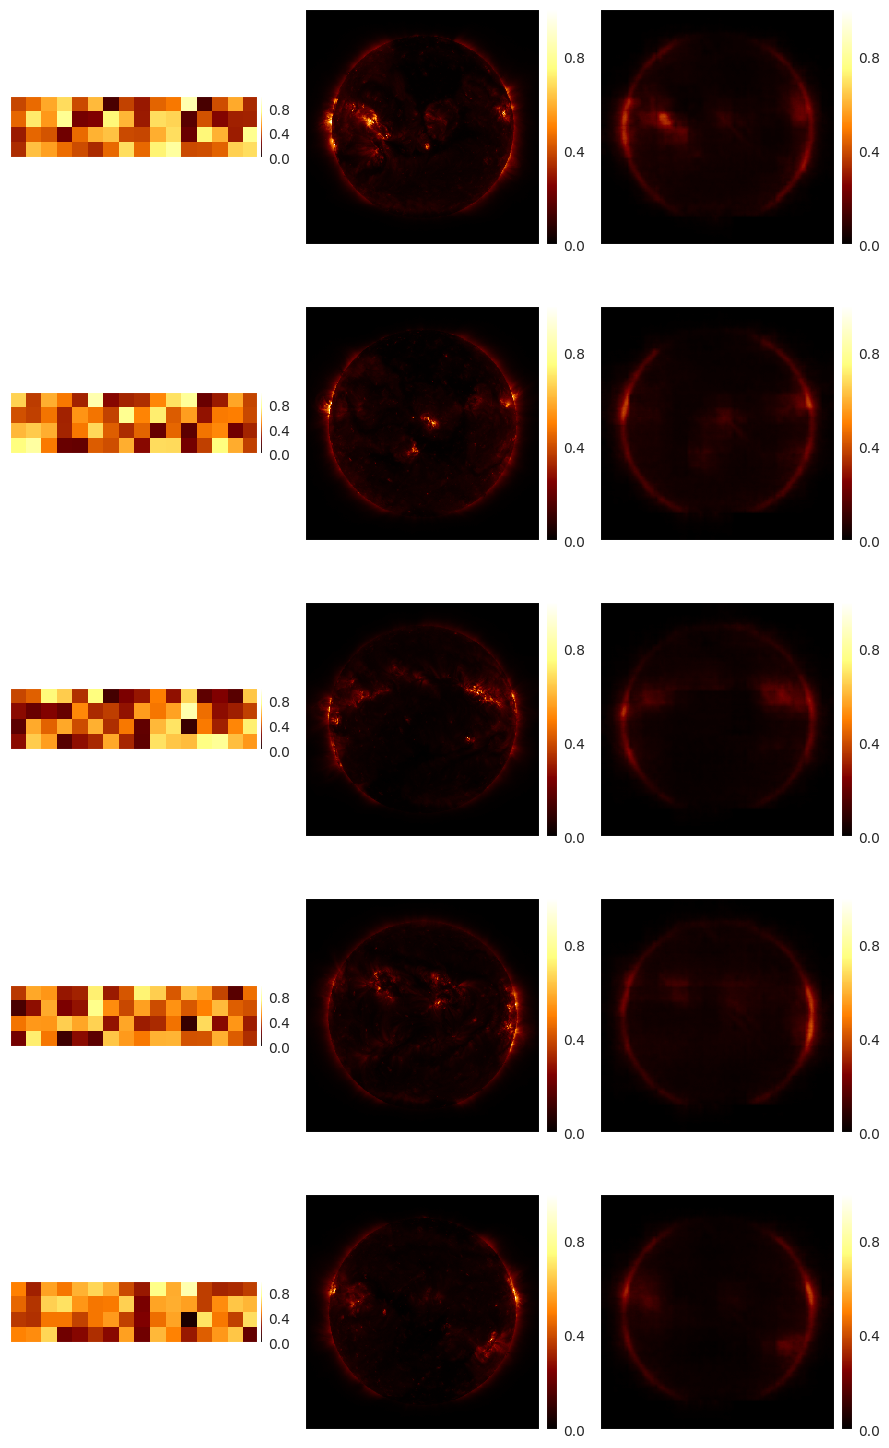

In [13]:
idx = np.random.permutation(clean_input_test.shape[0])[:5]

example = clean_input_test[idx, :, :]
code = encoder.predict(example)
reconstructed = decoder(code)

images_zipped = [i for i in zip(code, example, reconstructed)]
images = []

for i in images_zipped:
    images.append(np.reshape(i[0], [4,16]))
    images.append(np.squeeze(i[1]))
    images.append(np.squeeze(i[2]))
    

isns.ImageGrid(images, cmap="afmhot", vmin=0, vmax=1)